In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json

DATASET = "Lo"

with open(f"results/target_baseline_assessment_{DATASET}.json") as f:
    data = json.load(f)

baseline = f"{DATASET}-Clustered-MT-Chemprop"
# baseline = "TVT-ST-Chemprop"
comparison = f"{DATASET}-Clustered-MT-Chemprop-KD"
metric = "MSE"

comparison_dict = {}
for key in (baseline, comparison):
    comparison_dict[key] = {
        target: data[key][target][metric]
        for target in data[key]
    }

delta_df = pd.DataFrame(comparison_dict)
delta_df["Delta"] = delta_df[comparison] - delta_df[baseline]
delta_df["Delta"] = delta_df["Delta"].apply(lambda x: round(x, 3))
delta_df = delta_df.sort_values("Delta", ascending=True)
delta_df.sample(10)

,Lo-Clustered-MT-Chemprop,Lo-Clustered-MT-Chemprop-KD,Delta
RECQL,0.969089,0.906406,-0.063
HSPA5,0.388572,0.326421,-0.062
ATM,0.484021,0.527850,0.044
POLK,0.241774,0.225801,-0.016
PIM3,1.399306,0.807186,-0.592
RORC,0.461683,0.473286,0.012
SLC6A2,1.192266,1.238184,0.046
PAX8,0.640270,0.642322,0.002
GHSR,1.695677,1.869380,0.174
RET,1.136741,1.009693,-0.127


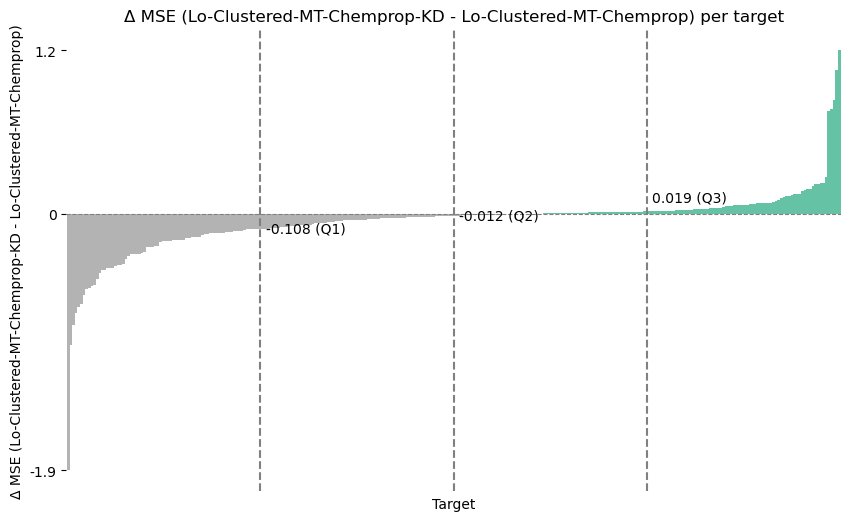

In [2]:
pallete = sns.color_palette("Set2")
tuple_to_hex = lambda x: "#{:02x}{:02x}{:02x}".format(*(int(x*255) for x in x))

figure = plt.figure(figsize=(10, 6))
# https://seaborn.pydata.org/tutorial/color_palettes.html#using-categorical-color-brewer-palettes
delta_df["Delta"].plot(kind="bar", color=np.where(
    delta_df["Delta"] < 0, tuple_to_hex(pallete[-1]), tuple_to_hex(pallete[0])
), align='edge', width=1)
plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')
plt.ylabel(f"Δ {metric} ({comparison} - {baseline})")
plt.title(f"Δ {metric} ({comparison} - {baseline}) per target")
plt.xlabel("Target")
# Remove the x-ticks
plt.xticks([])
# Set y-ticks to minimum, maximum, and 0
plt.yticks([delta_df["Delta"].min(), 0, delta_df["Delta"].max()])
# Set y-tick labels to the minimum, maximum, and 0
plt.gca().set_yticklabels([f"{delta_df['Delta'].min():.1f}", 0, f"{delta_df['Delta'].max():.1f}"])

# Remove borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Draw lines at 0%, 25%, 50%, 75%, and 100% of the x-axis, writing the corresponding values
total = len(delta_df)
for i in range(25, 76, 25):
    x = i/100 * total
    value = delta_df.iloc[int(x)]["Delta"]
    text = f"{value} (Q{i//25})"
    plt.axvline(x=x, color='gray', linestyle='--')
    offset = 0.05 if value > 0 else -0.05
    plt.text(x+2, value+offset, text, rotation=0, verticalalignment='bottom')

plt.show()

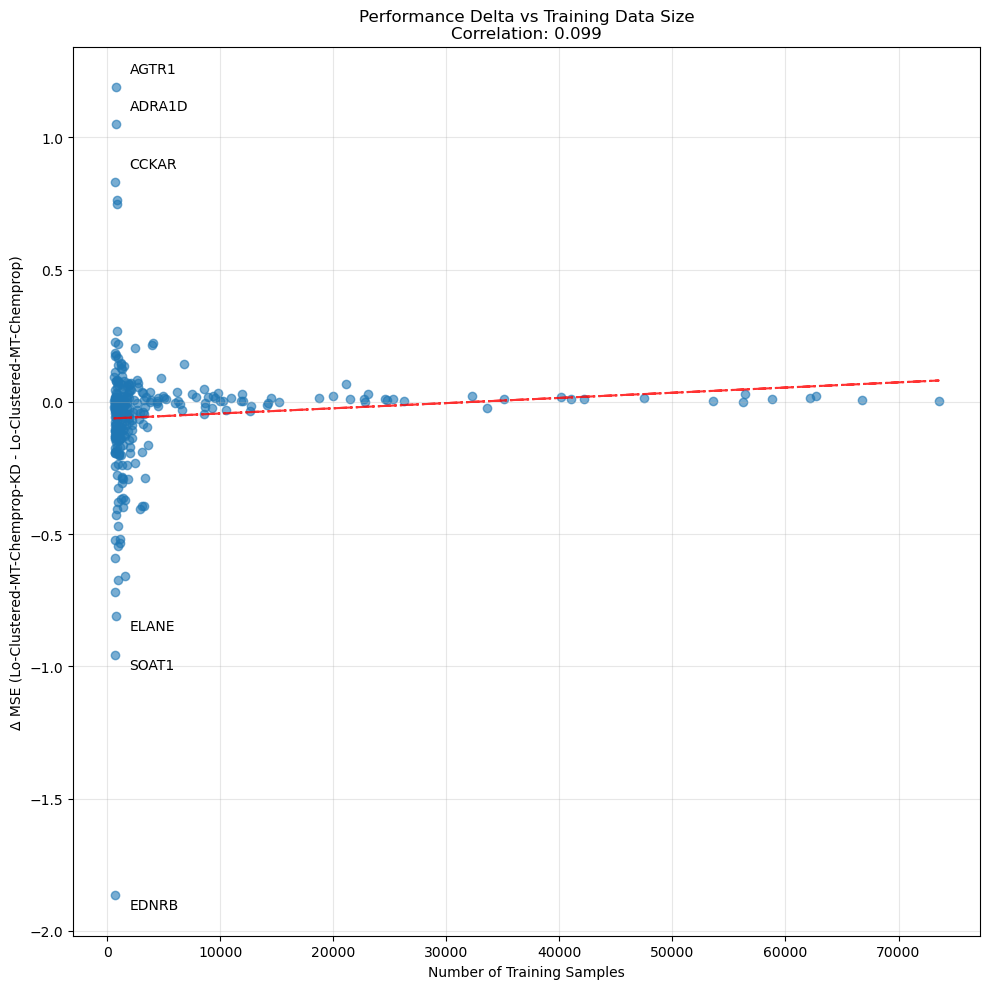

In [3]:
# Load the dataset and filter for train split
df = pd.read_csv("data/pivoted_pXC50_over_1000_split.csv")
train_df = df[df["split"] == "train"]

# Count non-null values for each column except SMILES and split
counts = train_df.drop(columns=["SMILES", "split"]).notna().sum().sort_values(ascending=False)

# Merge counts with delta_df to analyze performance vs training data
merged_df = pd.merge(delta_df, counts.rename("train_samples"), 
                    left_index=True, right_index=True)

# Drop outliers in Delta and counts using IQR
# Q1 = merged_df["Delta"].quantile(0.25)
# Q3 = merged_df["Delta"].quantile(0.75)
# IQR = Q3 - Q1
# merged_df = merged_df[merged_df["Delta"].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)]

# Q1 = merged_df["train_samples"].quantile(0.25)
# Q3 = merged_df["train_samples"].quantile(0.75)
# IQR = Q3 - Q1
# merged_df = merged_df[merged_df["train_samples"].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)]

# Create scatter plot
plt.figure(figsize=(10, 10))

# Plot points
plt.scatter(merged_df["train_samples"], merged_df["Delta"], alpha=0.6)

# Add trend line
z = np.polyfit(merged_df["train_samples"], merged_df["Delta"], 1)
p = np.poly1d(z)
plt.plot(merged_df["train_samples"], p(merged_df["train_samples"]), "r-.", alpha=0.8)

# Calculate correlation
corr = merged_df["train_samples"].corr(merged_df["Delta"])

# Annotate plot
plt.xlabel("Number of Training Samples")
plt.ylabel(f"Δ {metric} ({comparison} - {baseline})")
plt.title(f"Performance Delta vs Training Data Size\nCorrelation: {corr:.3f}")

# Add grid
plt.grid(True, alpha=0.3)

# Annotate some interesting points
for idx, row in merged_df.nlargest(3, "Delta").iterrows():
    plt.annotate(idx, (row["train_samples"], row["Delta"]), 
                xytext=(10, 10), textcoords='offset points')
for idx, row in merged_df.nsmallest(3, "Delta").iterrows():
    plt.annotate(idx, (row["train_samples"], row["Delta"]),
                xytext=(10, -10), textcoords='offset points')

plt.tight_layout()
plt.show()

/tmp/ipykernel_1221536/346827479.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_stats = merged_df.groupby("bin").agg({


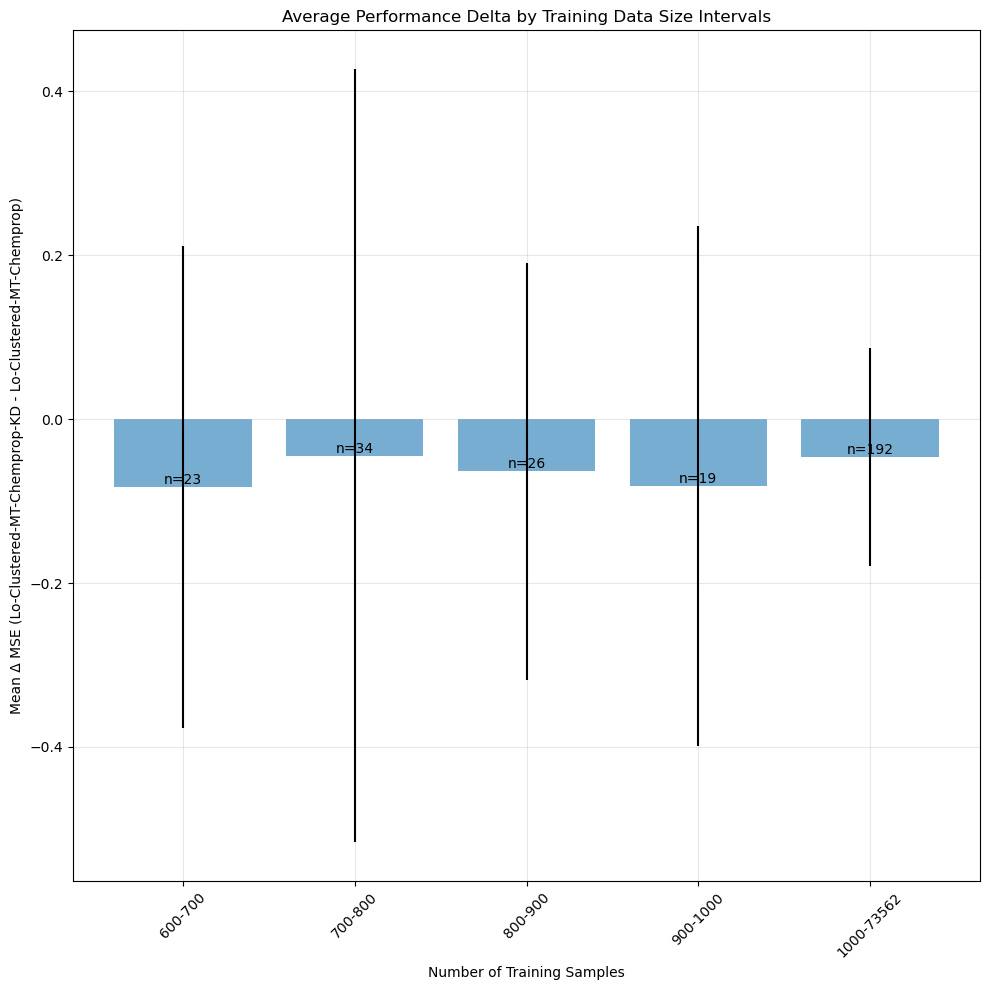

In [4]:
# bins = np.linspace(merged_df["train_samples"].min(), 
#                   merged_df["train_samples"].max(),
#                   num=20)  # Create 10 equally spaced bins

# Create bins for training sample counts according to quantiles of 10% steps
# bins = []
# for i in range(0, 101, 10):
#     bins.append(merged_df["train_samples"].quantile(i/100))

bins = [600, 700, 800, 900, 1000, merged_df["train_samples"].max()]

# Add bin labels to dataframe
merged_df["bin"] = pd.cut(merged_df["train_samples"], bins)

# Calculate mean delta and count per bin
binned_stats = merged_df.groupby("bin").agg({
    "Delta": ["mean", "std", "count"],
    "train_samples": "mean"
}).reset_index()

# Flatten column names
binned_stats.columns = ["bin", "delta_mean", "delta_std", "samples_per_bin", "samples_mean"]

# Create bar plot
plt.figure(figsize=(10, 10))

# Plot bars
plt.bar(range(len(binned_stats)), 
        binned_stats["delta_mean"],
        yerr=binned_stats["delta_std"],
        alpha=0.6)

# Customize x-axis
plt.xticks(range(len(binned_stats)), 
          [f"{int(b.left)}-{int(b.right)}" for b in binned_stats["bin"]], 
          rotation=45)

# Add labels
plt.xlabel("Number of Training Samples")
plt.ylabel(f"Mean Δ {metric} ({comparison} - {baseline})")
plt.title("Average Performance Delta by Training Data Size Intervals")

# Add sample counts above bars
for i, count in enumerate(binned_stats["samples_per_bin"]):
    plt.text(i, binned_stats["delta_mean"][i], 
             f"n={int(count)}", 
             ha="center", va="bottom")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import json
import pandas as pd

with open("results/aggregated_baseline_assessment.json") as f:
    data_tvt = json.load(f)

with open(f"results/aggregated_baseline_assessment_Lo.json") as f:
    data_lo = json.load(f)

with open(f"results/aggregated_baseline_assessment_Hi.json") as f:
    data_hi = json.load(f)

df = pd.concat([
    pd.DataFrame(data_tvt).T,
    pd.DataFrame(data_lo).T,
    pd.DataFrame(data_hi).T
])

# Create multi-index from index
# Split index by - and take the first element as the first level
# Split index by - and take the second element as the second level
df.index = pd.MultiIndex.from_tuples(
    [(index.split("-")[0], "-".join(index.split("-")[1:])) for index in df.index]
)

one_hot =[
    [r"\checkmark" if "MT" in name else "" for name in df.index.get_level_values(1)],
    [r"\checkmark" if "Clustered" in name else "" for name in df.index.get_level_values(1)],
    [r"\checkmark" if "KD" in name else "" for name in df.index.get_level_values(1)],
]

for col in df.columns:
    df[col] = df[col].apply(lambda x: f"{x['mean']:.3f} ± {x['std']:.2f}")

df = df.assign(
    MT=one_hot[0],
    Clustered=one_hot[1],
    KD=one_hot[2],
)

# columns_order = ["Technique", "MT", "Clustered", "KD", "MSE", "MAE", "R2"]
columns_order = [ "MT", "Clustered", "KD", "MSE", "MAE", "R2"]
# df = df.reset_index(level=1).rename(columns={"level_1": "Technique"})
df = df[columns_order]

latex = df.to_latex(
    index=True,
    caption="Comparison of ML Model Performance Metrics",  # The caption to appear above the table in the LaTeX document
    label="tab:baselines",  # A label used for referencing the table within the LaTeX document
    position="htbp",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
    column_format="lccc",  # The format of the columns: left-aligend first column and center-aligned remaining columns as per APA guidelines
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
    float_format="{:0.2f}".format,  # Formats floats to two decimal places
    multirow=True
)

print(latex)
df

\begin{table}[htbp]
\caption{Comparison of ML Model Performance Metrics}
\label{tab:baselines}
\begin{tabular}{lccc}
\toprule
 &  & MT & Clustered & KD & MSE & MAE & R2 \\
\midrule
\multirow[t]{5}{*}{TVT} & Clustered-MT-Chemprop & \checkmark & \checkmark &  & 0.554 ± 0.31 & 0.530 ± 0.16 & 0.376 ± 0.26 \\
 & Clustered-MT-Chemprop-KD & \checkmark & \checkmark & \checkmark & 0.505 ± 0.25 & 0.505 ± 0.14 & 0.414 ± 0.26 \\
 & ST-Chemprop &  &  &  & 0.514 ± 0.26 & 0.511 ± 0.14 & 0.408 ± 0.26 \\
 & MT-Chemprop & \checkmark &  &  & 0.594 ± 0.31 & 0.548 ± 0.16 & 0.345 ± 0.25 \\
 & Bambu &  &  &  & 0.628 ± 0.36 & 0.554 ± 0.18 & 0.319 ± 0.25 \\
\cline{1-8}
\multirow[t]{6}{*}{Lo} & Clustered-MT-Chemprop & \checkmark & \checkmark &  & 1.099 ± 0.68 & 0.759 ± 0.29 & 0.017 ± 0.21 \\
 & Clustered-MT-Chemprop-KD & \checkmark & \checkmark & \checkmark & 1.046 ± 0.65 & 0.742 ± 0.28 & 0.052 ± 0.20 \\
 & ST-Chemprop &  &  &  & 1.077 ± 0.68 & 0.755 ± 0.29 & 0.031 ± 0.21 \\
 & MT-Chemprop & \checkmark &  &  & 

MT   Clustered          KD  \
TVT Clustered-MT-Chemprop     \checkmark  \checkmark               
    Clustered-MT-Chemprop-KD  \checkmark  \checkmark  \checkmark   
    ST-Chemprop                                                    
    MT-Chemprop               \checkmark                           
    Bambu                                                          
Lo  Clustered-MT-Chemprop     \checkmark  \checkmark               
    Clustered-MT-Chemprop-KD  \checkmark  \checkmark  \checkmark   
    ST-Chemprop                                                    
    MT-Chemprop               \checkmark                           
    MT-Chemprop-KD            \checkmark              \checkmark   
    Bambu                                                          
Hi  Clustered-MT-Chemprop     \checkmark  \checkmark               
    Clustered-MT-Chemprop-KD  \checkmark  \checkmark  \checkmark   
    ST-Chemprop                                                    
    MT-Chemprop               \checkmark                           
    MT-Chemprop-KD            \checkmark              \checkmark   
    Bambu                                                          

                                       MSE           MAE             R2  
TVT Clustered-MT-Chemprop     0.554 ± 0.31  0.530 ± 0.16   0.376 ± 0.26  
    Clustered-MT-Chemprop-KD  0.505 ± 0.25  0.505 ± 0.14   0.414 ± 0.26  
    ST-Chemprop               0.514 ± 0.26  0.511 ± 0.14   0.408 ± 0.26  
    MT-Chemprop               0.594 ± 0.31  0.548 ± 0.16   0.345 ± 0.25  
    Bambu                     0.628 ± 0.36  0.554 ± 0.18   0.319 ± 0.25  
Lo  Clustered-MT-Chemprop     1.099 ± 0.68  0.759 ± 0.29   0.017 ± 0.21  
    Clustered-MT-Chemprop-KD  1.046 ± 0.65  0.742 ± 0.28   0.052 ± 0.20  
    ST-Chemprop               1.077 ± 0.68  0.755 ± 0.29   0.031 ± 0.21  
    MT-Chemprop               1.164 ± 0.71  0.785 ± 0.28  -0.063 ± 0.32  
    MT-Chemprop-KD            1.113 ± 0.72  0.769 ± 0.31   0.017 ± 0.19  
    Bambu                     1.155 ± 0.74  0.768 ± 0.31  -0.019 ± 0.23  
Hi  Clustered-MT-Chemprop     1.341 ± 1.14  0.854 ± 0.40  -0.319 ± 0.60  
    Clustered-MT-Chemprop-KD  1.234 ± 0.99  0.829 ± 0.38  -0.186 ± 0.38  
    ST-Chemprop               1.279 ± 1.05  0.842 ± 0.40  -0.210 ± 0.37  
    MT-Chemprop               1.419 ± 1.30  0.865 ± 0.41  -0.429 ± 0.83  
    MT-Chemprop-KD            1.268 ± 1.04  0.839 ± 0.40  -0.202 ± 0.37  
    Bambu                     1.066 ± 1.10  0.715 ± 0.38  -0.068 ± 0.60

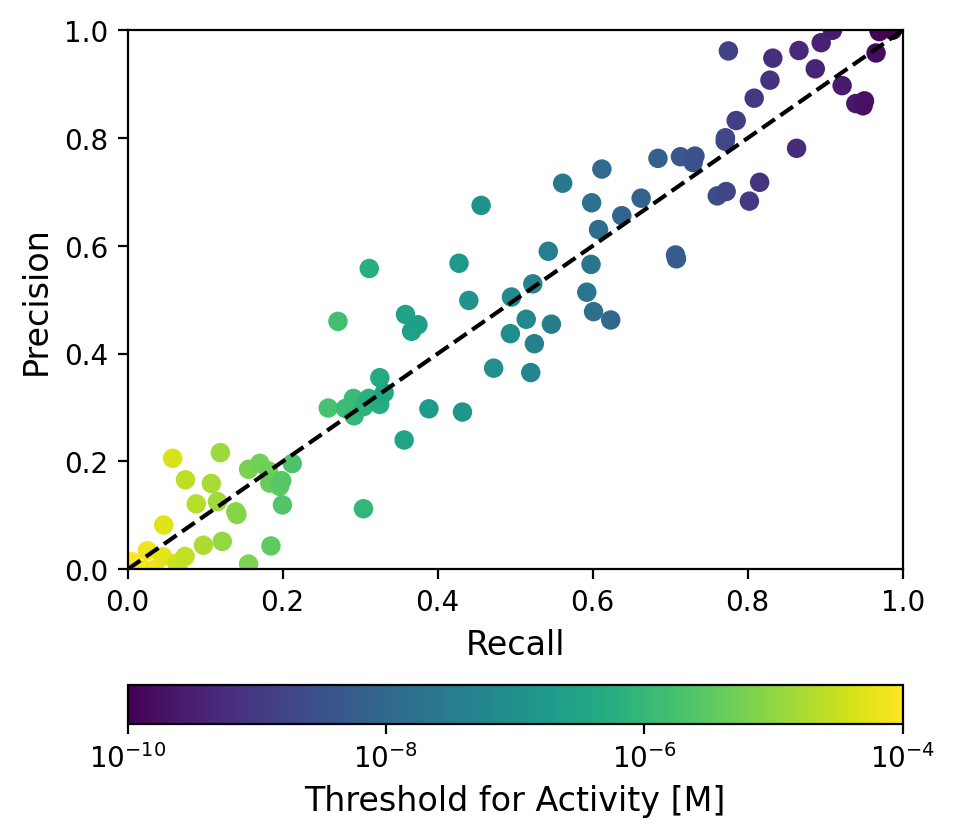

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Generate synthetic data similar to the given plot
np.random.seed(42)
n_points = 100
recall = np.sort(np.random.rand(n_points))  # Sorted recall values
precision = np.clip(recall + np.random.normal(0, 0.1, n_points), 0, 1)  # Noisy precision
thresholds = np.logspace(-4, -10, num=n_points)  # Threshold values from 10^-4 to 10^-10

# Create DataFrame
df = pd.DataFrame({'recall': recall, 'precision': precision, 'threshold': thresholds})

# Initialize figure
fig, ax = plt.subplots(figsize=(5, 5), dpi=200)

# Scatter plot with color corresponding to threshold (using LogNorm)
sc = ax.scatter(
    df["recall"], df["precision"], 
    c=df["threshold"], 
    cmap="viridis", 
    norm=mcolors.LogNorm(vmin=thresholds.min(), vmax=thresholds.max()),  # Log scale normalization
    edgecolors=None
)

# Dashed diagonal line (y = x)
ax.plot([0, 1], [0, 1], linestyle="--", color="black")

# Labels
ax.set_xlabel("Recall", fontsize=12)
ax.set_ylabel("Precision", fontsize=12)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Colorbar with log scale ticks
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.15)
cbar.set_label("Threshold for Activity [M]", fontsize=12)

# Remove small tick marks (minor ticks and major tick lines)
cbar.ax.tick_params(axis='both', which='minor', length=0)  # Removes all tick lines

# Set log-scaled ticks evenly spaced
cbar.set_ticks([1e-4, 1e-6, 1e-8, 1e-10], minor=False)
cbar.set_ticklabels([r"$10^{-4}$", r"$10^{-6}$", r"$10^{-8}$", r"$10^{-10}$"], minor=False)  # Scientific notation

plt.show()